# Project Results and Discussion

Here are my results for this small project (which I really enjoyed and learned a lot from ^^).

---

## 1. Synthetic Data Generation

I first simulated **PK dynamics** by translating the original code from **Julia to Python** and adding **Gaussian noise**, which can be controlled via the *`scale`* parameter in the `pk_generate_synthetic_data_python` function.

I extended as asked this generaton to a **PK/PD dynamic** by introducing an effect component. Data generation in this case is done by the `pkpd_generate_synthetic_data_python` function.

This function has the following parameters:

- `Ke`
- `kin`
- `Emax`
- `EC50`
- `seed`
- `scale_c`
- `scale_e`

The `seed` parameter ensures full reproducibility of the results.

---

## 2. Training Setup

I generated data for **6 patients** (instead of the 10 initially requested, hopiing this will not be held against me ^^) and trained the models.

From the runs I performed, **jointly optimizing concentration (C) and effect (E)** proved to be very hard. To fix this, I adopted the following strategy:

1. Train a first model to predict **C**.
2. Train a second model to predict **E**.
3. Fine-tune the **E model** using the concentrations predicted by the **C model**.

This approach led to **very strong results** using only:
- `grid_size = 2`
- a single hidden layer of size **20**

I believe this intermediate layer could be reduced further. I name this architecture the **DualKAN** model.

---

## 3. Spline Visualization

I also implemented a function to **visualize the learned splines**. However, I avoid to interpret, as I have no clue about it.

---

## 4. Cluster Training and Artifacts

Finally, I included the training setup that I ran on a **cluster**, which allows saving:
- plots,
- metrics,
- and other related artifacts.

This training was **not executed inside the notebook**, but the code is shown for the final submission.

All generated artifacts are stored in their **respective directories**, making it possible to reload:
- datasets,
- metrics,
- and plots.

---

## 5. Code Readability

I did my best to make the code as **clear and readable as possible**, by adding comments. However, due to time constraints these comments remain relatively brief.

---

## 6. Future Directions

With more time, I would have explored the integration of **patient-specific physiological features** (ie body weight, concentration of a protein in the blood, etc).

I would also have conducted a **statistical analysis of the models**, to assess if the observed improvements are statistically significant or not. Requiring to generate a larger number of patients and running the same models multiple times with different random initializations.

Another interesting direction would be to explore an alternative training strategy based on **joint but staged learning**, for instance by training the network on concentration prediction for a few steps, then on effect prediction for a few steps, using the output of the concentration model as input to the effect model.

I would also investigate **extreme model behaviors** by pushing the hyperparameter analysis further, for example by studying the sensitivity of the models to key hyperparameters.

Finally, a deeper effort could be made to **explain the model outputs** by conducting an analysis of the learned spline functions.

---

Once again **thank you very much for this project !**  
It was enjoyable and educational !

In [217]:
%load_ext autoreload
%autoreload 2

import utils
import simulation_tools
import numpy as np
import torch
from src.models import KAN, DualKAN
import pickle as pkl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from itertools import product
from typing import Callable
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Reproduce the baseline PK (single patient).

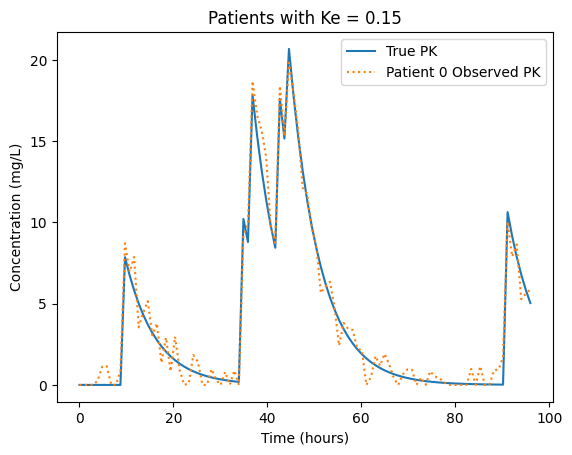

In [128]:
SEED: int = 12
scale_c: float = 1
np.random.seed(SEED)
utils.pk_plot_true_vs_observed(np.array([simulation_tools.pk_generate_synthetic_data_python(Ke=np.random.random(), SEED=SEED, scale=scale_c)])[None, ...])

### Implement deterministic data generation and save parameters + splits.


### Extend to PK/PD dynamics: decide on PD structure

1) We adopt the standard PK/PD structure commonly used in the literature, where the pharmacokinetics (PK) describe the drug concentration dynamics and the pharmacodynamics (PD) describe the drug effect dynamics.

\begin{aligned}
\frac{dC(t)}{dt} &= -K_e \, C(t), \\
\frac{dE(t)}{dt} &= k_{in} \left( \frac{E_{\max} \, C(t)}{EC_{50} + C(t)} - E(t) \right).
\end{aligned}

In [219]:
# Loading the data
with open('data/PATIENTS.pkl', 'rb') as f:
    PATIENTS: dict[str: np.ndarray[simulation_tools.pkpd_SyntheticPatientData]] = pkl.load(f)

# dim(PATIENTS_X) = (Ke_type, N_x)
PATIENTS_train: np.ndarray[simulation_tools.pkpd_SyntheticPatientData] = PATIENTS["train"]
PATIENTS_test: np.ndarray[simulation_tools.pkpd_SyntheticPatientData] = PATIENTS["test"]
PATIENTS_eval: np.ndarray[simulation_tools.pkpd_SyntheticPatientData] = PATIENTS["eval"]

PATIENTS = {
    i: np.concatenate([PATIENTS_train[i], PATIENTS_train[i], PATIENTS_train[i]], axis=0) for i in range(PATIENTS_train.shape[0])
}

print(f"Train size: {PATIENTS_train.shape[1]}")
print(f"Test size: {PATIENTS_test.shape[1]}")
print(f"Eval size: {PATIENTS_eval.shape[1]}")

for Ke_type in PATIENTS:
    print("------------------------------")
    print(f"Ke_type number {Ke_type}:")
    print(f"Total patient generated: {PATIENTS[Ke_type].shape[0]}")
    print(f"Ke: {round(PATIENTS[Ke_type][0].Ke, 2)}")
    print(f"kin: {round(PATIENTS[Ke_type][0].kin, 2)}")
    print(f"Emax: {round(PATIENTS[Ke_type][0].Emax, 2)}")
    print(f"EC50: {round(PATIENTS[Ke_type][0].EC50, 2)}")

print("------------------------------")

Train size: 2
Test size: 2
Eval size: 2
------------------------------
Ke_type number 0:
Total patient generated: 6
Ke: 0.17
kin: 1.26
Emax: 1.05
EC50: 4.44
------------------------------
Ke_type number 1:
Total patient generated: 6
Ke: 0.3
kin: 3.33
Emax: 0.8
EC50: 6.4
------------------------------
Ke_type number 2:
Total patient generated: 6
Ke: 0.08
kin: 1.08
Emax: 1.21
EC50: 4.38
------------------------------


In [220]:
# Create the tensor of shape (Ke_type, N_x, T_x)
C_train, E_train, t_train = list(map(torch.Tensor, utils.C_E_t_matrices(PATIENTS_train)))
C_test, E_test, t_test = list(map(torch.Tensor, utils.C_E_t_matrices(PATIENTS_test)))
C_eval, E_eval, t_eval = list(map(torch.Tensor, utils.C_E_t_matrices(PATIENTS_eval)))

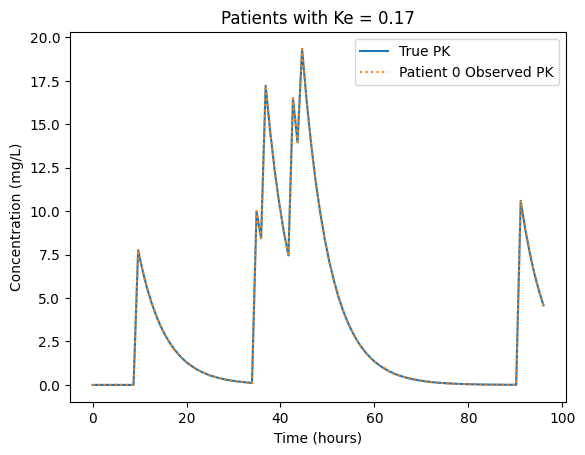

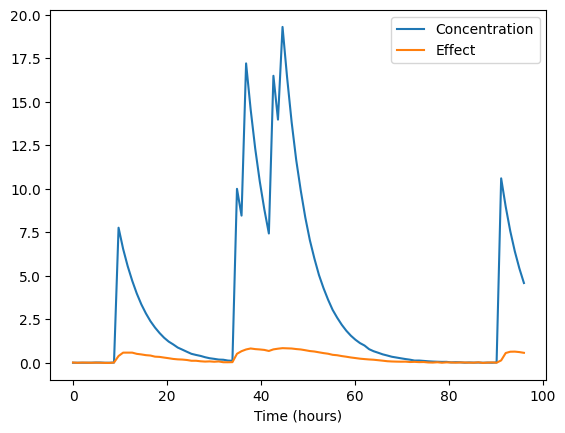

In [221]:
# Plot the observed concentration and the true concentration
# I added almost no noise here ...
utils.pk_plot_true_vs_observed(np.array([PATIENTS_train[0]]))

# Plot concentration and effect
utils.pkpd_plot(PATIENTS_train[0, 0])

### Implement population training and evaluation.

In [222]:
# Load the config
with open('models/config.pkl', 'rb') as f:
    config: dict[str: int | dict[str: float | list[int]]] = pkl.load(f)

Ke_type_pretrained: int = config["Ke_type"]
hyperparams: dict[str: float | list[int]] = config["hyperparams"]

# Load the best model for concentration
model_concentration = KAN(layers_hidden=hyperparams["layers_hidden"], grid_size=hyperparams["grid_size"])
state_dict_concentration = torch.load('models/best_model_concentration.pth', map_location=device)
model_concentration.load_state_dict(state_dict_concentration)

# Load the best model for effect
model_effect = KAN(layers_hidden=hyperparams["layers_hidden"], grid_size=hyperparams["grid_size"])
state_dict_effect = torch.load('models/best_model_effect.pth', map_location=device)
model_effect.load_state_dict(state_dict_effect)

<All keys matched successfully>

In [223]:
# hyperparameter optimization coupled with the occam razor principle
hyperparams

{'lr': 0.01,
 'epochs': 20,
 'pace_eval': 5,
 'layers_hidden': [2, 20, 2],
 'grid_size': 2}

[C, E] -> model_concentration -> [dCdt, _]

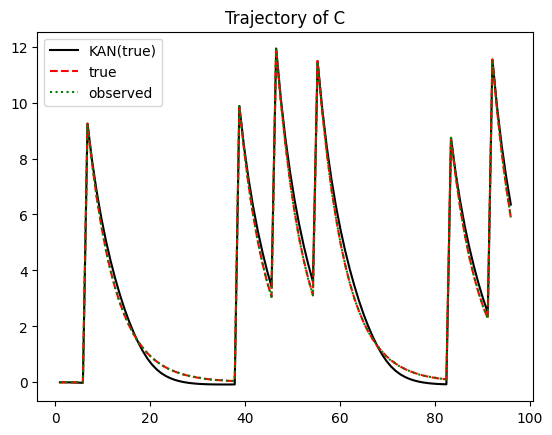

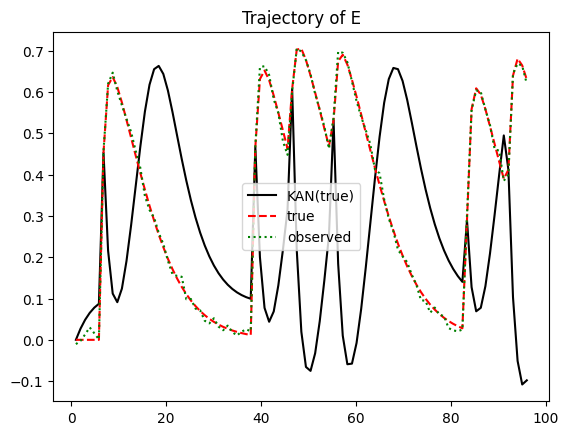

In [90]:
# On the eval for concentration
utils.pkpd_plot_evaluate_model(model_concentration, PATIENTS_test[Ke_type_pretrained, 0], torch.concat([C_test[Ke_type_pretrained, 0][..., None], E_test[Ke_type_pretrained, 0][..., None]], dim=-1), torch.Tensor(t_test[Ke_type_pretrained, 0]))

[C, E] -> model_effect -> [_, dEdt]

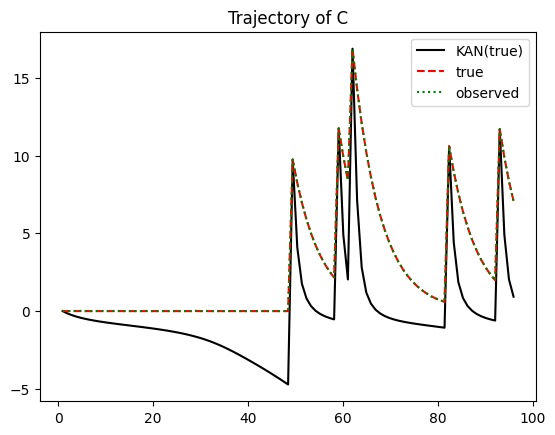

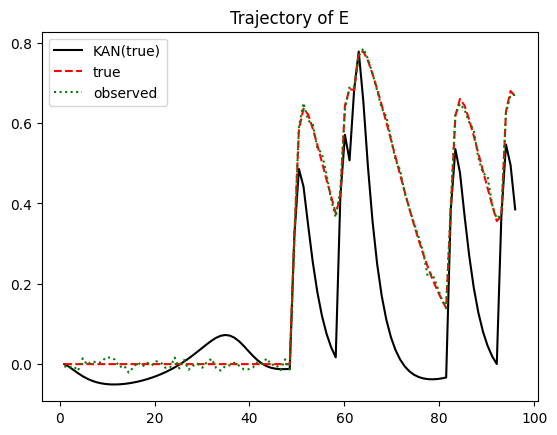

In [91]:
# On the eval for effect
utils.pkpd_plot_evaluate_model(model_effect, PATIENTS_eval[Ke_type_pretrained, 0], torch.concat([C_eval[Ke_type_pretrained, 0][..., None], E_eval[Ke_type_pretrained, 0][..., None]], dim=-1), torch.Tensor(t_eval[Ke_type_pretrained, 0]))

[C, E] -> model_DualKAN -> [model_concentration, model_effect] -> [dCdt, dEdt]

In [ ]:
model_DualKAN = DualKAN(concentration_KAN=model_concentration, effect_KAN=model_effect)

for p in model_DualKAN.concentration_KAN.parameters():  p.requires_grad = True
for p in model_DualKAN.effect_KAN.parameters():  p.requires_grad = True

# Freeze the concentration to train only the effect
# Comment it, if you want to train the model_effect
for p in model_DualKAN.concentration_KAN.parameters():  p.requires_grad = False

# Freeze the effect to train only the model_concentration
# Comment it, if you want to train the model_concentration
for p in model_DualKAN.effect_KAN.parameters():  p.requires_grad = False

# I have tested the joint optimization but it performed poorly

In [135]:
# Train the effect
# Un-comment it, if you want to train the model_effect
#model_DualKAN = utils.train_KAN_for_pkpd(model_DualKAN, hyperparams, PATIENTS[Ke_type_pretrained], torch.concat([C_train[Ke_type_pretrained][..., None], E_train[Ke_type_pretrained][..., None]], dim=-1), torch.concat([C_test[Ke_type_pretrained][..., None], E_test[Ke_type_pretrained][..., None]], dim=-1), torch.Tensor(t_train[Ke_type_pretrained]), torch.Tensor(t_test[Ke_type_pretrained]), device, 0, 100)

# Train the concentration
# Un-comment it, if you want to train the model_concentration
#model_DualKAN = utils.train_KAN_for_pkpd(model_DualKAN, hyperparams, PATIENTS[Ke_type_pretrained], torch.concat([C_train[Ke_type_pretrained][..., None], E_train[Ke_type_pretrained][..., None]], dim=-1), torch.concat([C_test[Ke_type_pretrained][..., None], E_test[Ke_type_pretrained][..., None]], dim=-1), torch.Tensor(t_train[Ke_type_pretrained]), torch.Tensor(t_test[Ke_type_pretrained]), device, 1, 0)

In [ ]:
#torch.save(model_concentration.state_dict(), 'models/best_model_concentration.pth')
#torch.save(model_effect.state_dict(), 'models/best_model_effect.pth')

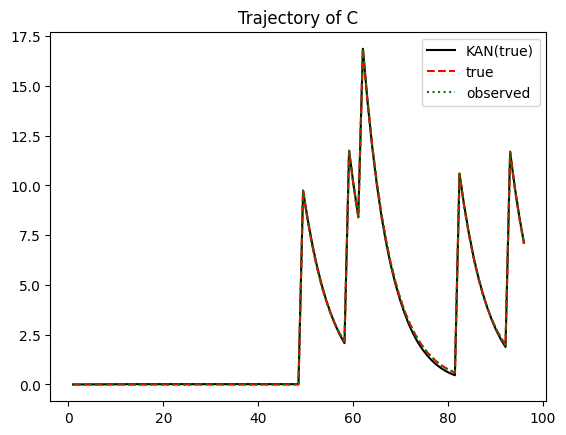

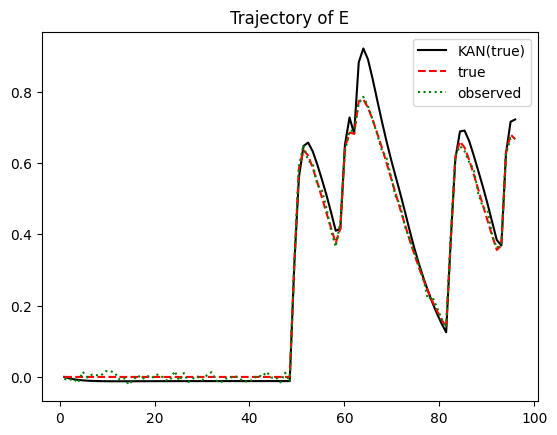

In [186]:
# On the eval for both
# Evaluation
utils.pkpd_plot_evaluate_model(model_DualKAN, PATIENTS_eval[Ke_type_pretrained, 0], torch.concat([C_eval[Ke_type_pretrained, 0][..., None], E_eval[Ke_type_pretrained, 0][..., None]], dim=-1), torch.Tensor(t_eval[Ke_type_pretrained, 0]))

In [187]:
# Evaluation
with torch.no_grad():
    print("-----------------------")
    Ke_pred = round(-model_DualKAN(torch.Tensor([1., 0.]))[0].item(), 3)
    Ke_true = round(PATIENTS[0][0].Ke, 3)

    print(f"{Ke_true=}\n{Ke_pred=}")
    print("-----------------------")

    kin_pred = round(-model_DualKAN(torch.tensor([0., 1.]))[-1].item(), 3)
    kin_true = round(PATIENTS[0][0].kin, 3)

    print(f"{kin_true=}\n{kin_pred=}")
    print("-----------------------")

    ratio_Emax_EC50p1_pred = round(model_DualKAN(torch.Tensor([1., 0.]))[-1].item() / kin_pred, 3)
    ratio_Emax_EC50p1_true = round(PATIENTS[0][0].Emax / (PATIENTS[0][0].EC50 + 1), 3)

    print(f"{ratio_Emax_EC50p1_pred=}\n{ratio_Emax_EC50p1_true=}")
    print("-----------------------")

-----------------------
Ke_true=0.173
Ke_pred=0.164
-----------------------
kin_true=1.255
kin_pred=0.537
-----------------------
ratio_Emax_EC50p1_pred=0.117
ratio_Emax_EC50p1_true=0.193
-----------------------


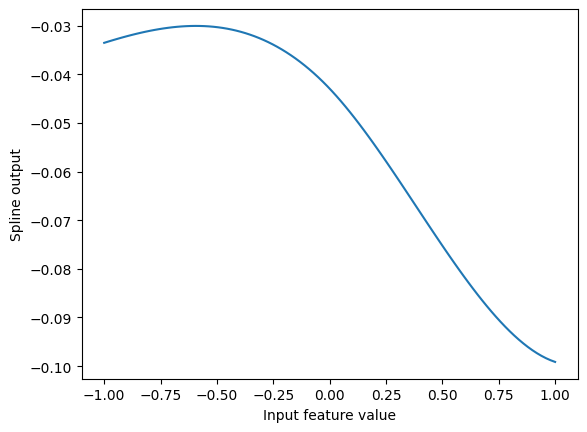

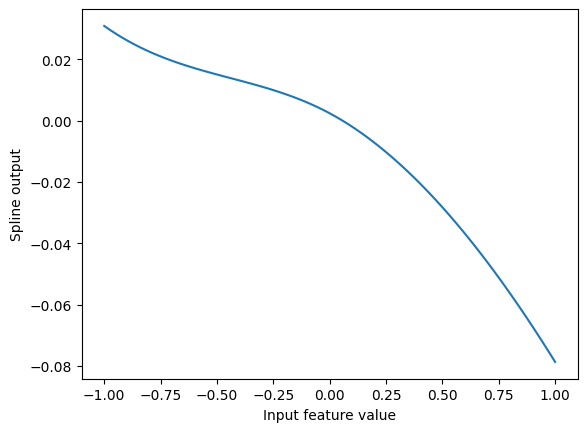

In [224]:
# Validation
utils.plot_splines(model_concentration.layers[0], in_feature=0, out_feature=0)
utils.plot_splines(model_effect.layers[0], in_feature=1, out_feature=1)

### Run grid search over grid_size, layer_width, and (bonus) layers.

### Save checkpoints, plots, and metrics for every run; produce a summary.

In [ ]:
sensibility: dict[str, list[float]] = {
    "lr": [0.01],
    "epochs": [10],
    "pace_eval": [1],
    "layers_hidden": [[2, 2, 2], [2, 10, 2], [2, 20, 2]],
    "grid_size": [8, 16, 32],
}

SETUPS: list[dict[str, list[float]]] = [
    dict(zip(sensibility.keys(), combo))
    for combo in product(*sensibility.values())
]

METRICS: list[tuple[str, Callable]] = [
    ("r2_score", r2_score),
    ("mean_absolute_error", mean_absolute_error),
    ("mean_squared_error", mean_squared_error),
    ("explained_variance_score", explained_variance_score)
]

for hyperparams_setup in SETUPS:

    for n in range(Ke_type):

        metrics_C: dict[str, float] = {metric_name: 0 for (metric_name, _) in METRICS}
        metrics_E: dict[str, float] = {metric_name: 0 for (metric_name, _) in METRICS}

        model: KAN = KAN(layers_hidden=hyperparams_setup["layers_hidden"], grid_size=hyperparams_setup["grid_size"])
        model: KAN = utils.train_KAN_for_pkpd(model, hyperparams_setup, PATIENTS[n], torch.concat([C_train[n][..., None], E_train[n][..., None]], dim=-1), torch.concat([C_test[n][..., None], E_test[n][..., None]], dim=-1), torch.Tensor(t_train[n]), torch.Tensor(t_test[n]), device, 1, 1, n, True)
        
        C_PREDS, E_PREDS, C_TRUES, E_TRUES, _ = utils.pkpd_pred_true_trajectory(model, PATIENTS_eval[n], torch.concat([C_eval[n], E_eval[n]], dim=-1), torch.Tensor(t_eval[n]))

        for (metric_name, metric_f) in METRICS:

            for j in range(len(C_PREDS)):

                pred_C: np.ndarray[float] = C_PREDS[j].item()
                pred_E: np.ndarray[float] = E_PREDS[j].item()

                true_C: np.ndarray[float] = C_TRUES[j].item()
                true_E: np.ndarray[float] = E_TRUES[j].item()
                
                metrics_C[metric_name] += (metric_f(true_C, pred_C) / len(E_PREDS))
                metrics_E[metric_name] += (metric_f(true_E, pred_E) / len(E_PREDS))

        with open(f"metrics/kt_{n}_gs_{hyperparams_setup["grid_size"]}_hl_{hyperparams_setup["layers_hidden"][1]}.pkl", "wb") as f:
            pkl.dump(
                {"C": metrics_C, "E": metrics_E}, f
            )

        torch.save(model.state_dict(), f'models/kt_{n}_gs_{hyperparams_setup["grid_size"]}_hl_{hyperparams_setup["layers_hidden"][1]}.pth')